In [47]:
import numpy as np
import matplotlib.pyplot as plt
import hmp
import mne
import pandas as pd
import seaborn as sns
from scipy import stats

In [48]:
# -------------------------------
# Absolute timing (list) for one event
# -------------------------------

def event_abs_timing_list(eventprobs, event_n):
    """
    For a given event number, finds the time point in each trial where the event has the highest probability.

    Returns:
    - List of time indices (one per trial) where the given event is most probable (in sample indices).
    """
    trial_results = []

    for trial in range(len(eventprobs)):
        trial_probs = [eventprobs[trial][sample][event_n] for sample in range(len(eventprobs[trial]))]
        max_idx = trial_probs.index(max(trial_probs))
        trial_results.append(max_idx)

    return trial_results

# -------------------------------
# Absolute timing (DataFrame) for all events
# -------------------------------

def event_abs_timing_df(eventprobs, n_events):
    """
    Constructs a DataFrame showing, for each event, the sample index at which that event
    had the highest probability across trials.

    Returns:
    - DataFrame with shape (trials x events), with each value being the sample index of peak probability.
    """
    abs_timing_dict = {}

    for event in range(n_events):
        abs_timing_list = event_abs_timing_list(eventprobs, event)
        abs_timing_dict[event] = abs_timing_list

    return pd.DataFrame(abs_timing_dict)

# -------------------------------
# Relative timing (list) for one event
# -------------------------------

def event_rel_timing_list(eventprobs, rt, event_n):
    """
    Calculates the relative timing of a specific event within each trial, expressed as a proportion
    of the total reaction time.

    Returns:
    - List of relative timings (one per trial).
    """
    trial_results = []

    for trial in range(len(eventprobs)):
        trial_probs = [eventprobs[trial][sample][event_n] for sample in range(len(eventprobs[trial]))]
        max_idx = trial_probs.index(max(trial_probs))

        # Convert sample index to milliseconds (500 Hz = 2 ms per sample)
        event_ms = max_idx * 2
        rt_ms = rt[trial] * 1000

        trial_results.append(event_ms / rt_ms)

    return trial_results

# -------------------------------
# Relative timing (DataFrame) for all events
# -------------------------------

def event_rel_timing_df(eventprobs, rt, n_events):
    """
    Constructs a DataFrame showing, for each event, the relative timing (as a proportion of total trial duration)
    at which that event had the highest probability across trials.

    Returns:
    - DataFrame with shape (trials x events), with each value being the relative timing of peak probability.
    """
    rel_timing_dict = {}

    for event in range(n_events):
        rel_timing_list = event_rel_timing_list(eventprobs, rt, event)
        rel_timing_dict[event] = rel_timing_list

    return pd.DataFrame(rel_timing_dict)

# -------------------------------
# Mean spatial correlation across trials for each event
# -------------------------------

def corr_maps_per_event(event_abs_timing_df, epoch_data):
    """
    Calculates the mean spatial correlation of EEG topographies across trials for each event.

    Args:
        event_abs_timing_df: DataFrame with sample indices per trial (from event_abs_timing_df).
        epoch_data: Xarray with dimensions (epochs × channels × samples).
    
    Returns:
        List of mean pairwise correlations between topographies for each event.
    """
    event_corr_list = []

    for event in event_abs_timing_df.columns:
        matrix_of_values = []
        list_timing = event_abs_timing_df[event]

        for idx, sample_idx in enumerate(list_timing):
            values = epoch_data.isel(epochs=idx, samples=sample_idx).data.values[0]
            matrix_of_values.append(values)

        matrix_df = pd.DataFrame(matrix_of_values)
        similarity_matrix = matrix_df.T.corr()
        upper_triangle = similarity_matrix.where(np.triu(np.ones(similarity_matrix.shape), k=1).astype(bool))
        mean_corr = upper_triangle.stack().mean()
        event_corr_list.append(mean_corr)

    return event_corr_list

Opening raw data file subj_0102_preprocessed-raw.fif...
    Range : 0 ... 3616767 =      0.000 ...  1766.000 secs
Ready.
Reading 0 ... 3616767  =      0.000 ...  1766.000 secs...
['stim-all_stim' 'trial_end']
Shape of raw EEG data: (69, 3616768)


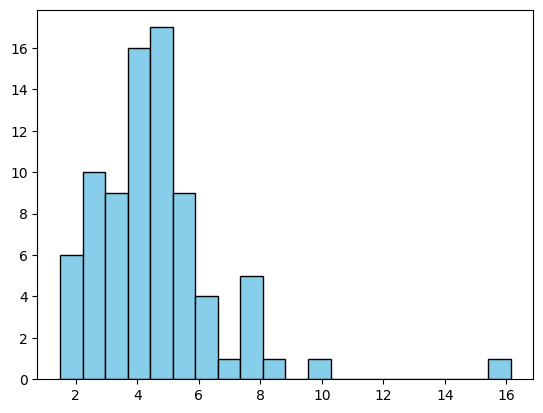

In [49]:
# -------------------------------
# Preparation of events array to Epoch simulated data
# -------------------------------

# Step 1: Load raw EEG data
raw = mne.io.read_raw_fif("subj_0102_preprocessed-raw.fif", preload=True)

# Step 2: Extract annotations
annotations = raw.annotations
onset = annotations.onset  # Onsets in seconds
description = annotations.description  # Annotation labels

# Step 3: Create annotation DataFrame
df = pd.DataFrame({
    "description": description,
    "onset": onset
})

# Step 4: Filter for trial start and end events
df_filtered = df[df["description"].isin(["stim-all_stim", "trial_end"])].reset_index(drop=True)
print(np.unique(df_filtered["description"]))

# Step 5: Plot distribution of RT
rt = []
for i in range(1, len(df_filtered), 2):  # step by 2 to get only odd indices
    rt.append(df_filtered.onset[i] - df_filtered.onset[i - 1])
rt = np.array(rt)
plt.hist(rt, bins=20, color='skyblue', edgecolor='black')

# Step 6: Map descriptions to event IDs
mapping = {"stim-all_stim": 1, "trial_end": 2}
df_filtered["event_id"] = df_filtered["description"].map(mapping)

# Step 7: Convert onset times from seconds to sample indices
sfreq = 2048  # Sampling frequency in Hz
df_filtered["sample"] = (df_filtered["onset"] * sfreq).astype(int)

# Step 8: Add a dummy 'previous' column for MNE formatting
df_filtered["previous"] = 0

# Step 9: Arrange columns to match MNE expected format
df_events = df_filtered[["sample", "previous", "event_id"]]

# Step 10: Convert events DataFrame to NumPy array
events = df_events.values

# Step 11: Define event and response IDs
event_id = {"stimulus": 1}
resp_id = {"response": 2}

# Step 12: Check shape of raw EEG data (for reference)
print("Shape of raw EEG data:", raw.get_data().shape)

In [50]:
# -------------------------------
# Preparation of noisy EEG data (raw object)
# -------------------------------

# 1. Create info object
montage = mne.channels.make_standard_montage('biosemi64')
info = mne.create_info(montage.ch_names, sfreq=2048, ch_types='eeg')
info.set_montage(montage)

# 2. Numpy array with same dimensions as true data
n_samples = int(info['sfreq'] * 1766)  # 1766 second of data
data = np.zeros((len(info['ch_names']), n_samples)) #Create numpy array filled with zeros

# 3. Create raw object
raw = mne.io.RawArray(data, info)
raw.set_eeg_reference(ref_channels='average')

# 4. Add noise to raw
cov = mne.make_ad_hoc_cov(info)
mne.simulation.add_noise(raw, cov, iir_filter=[0.2, -0.2, 0.04])

# 5. Save raw data to .fif file
raw.save('simulated_noise_raw.fif', overwrite=True)

Creating RawArray with float64 data, n_channels=64, n_times=3616768
    Range : 0 ... 3616767 =      0.000 ...  1766.000 secs
Ready.
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Adding noise to 64/64 channels (64 channels in cov)
Overwriting existing file.
Writing C:\Users\celia\Desktop\EEG data\Final Notebooks\simulated_noise_raw.fif
Closing C:\Users\celia\Desktop\EEG data\Final Notebooks\simulated_noise_raw.fif
[done]


[WindowsPath('C:/Users/celia/Desktop/EEG data/Final Notebooks/simulated_noise_raw.fif')]

Processing participant simulated_noise_raw.fif's continuous eeg
Opening raw data file simulated_noise_raw.fif...
    Range : 0 ... 3616767 =      0.000 ...  1766.000 secs
Ready.
Reading 0 ... 3616767  =      0.000 ...  1766.000 secs...
Downsampling to 500 Hz
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.7e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 165.16 Hz
- Upper transition bandwidth: 41.29 Hz (-6 dB cutoff frequency: 185.81 Hz)
- Filter length: 165 samples (0.081 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.4s


Creating epochs based on following event ID :[1 2]
Adding metadata with 2 columns
80 matching events found
Setting baseline interval to [-0.19921875, 0.0] s
Applying baseline correction (mode: mean)
Using data from preloaded Raw for 80 events and 31131 original time points (prior to decimation) ...
0 bad epochs dropped
Applying reaction time trim to keep RTs between 0 and 15.002 seconds
79 RTs kept of 80 clean epochs
79 trials were retained for participant simulated_noise_raw.fif
End sampling frequency is 500 Hz


  0%|          | 0/2216 [00:00<?, ?it/s]

Transition event 1 found around sample 26
Transition event 2 found around sample 183
Transition event 3 found around sample 569
Transition event 4 found around sample 949
Transition event 5 found around sample 1880
Transition event 6 found around sample 2208

All events found, refitting final combination.
Estimating 6 events model
parameters estimated for 6 events model


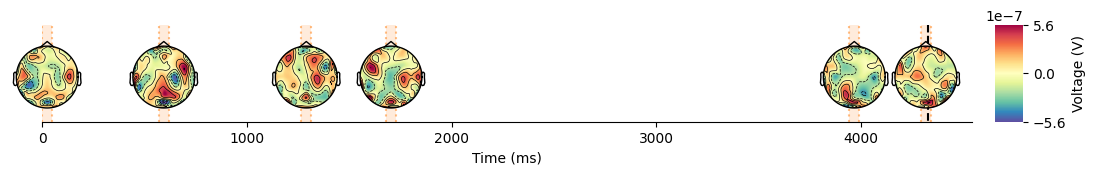

In [51]:
# -------------------------------
# HMP fitting on simulated data
# -------------------------------

# 1. Prepare data for HMP as usual
epoch_data = hmp.utils.read_mne_data('simulated_noise_raw.fif', event_id=event_id, resp_id=resp_id, sfreq=500, 
            events_provided=events, verbose=True, tmin=-0.2, tmax = 15)

# 2. Extract Channel Positions
channel_names = montage.ch_names
positions = np.array([montage.get_positions()['ch_pos'][ch][:2] for ch in channel_names])

# 3. Fit HMP model - 50 ms bump
hmp_data = hmp.utils.transform_data(epoch_data, apply_standard=False, n_comp = 10)
init = hmp.models.hmp(data=hmp_data, sfreq=epoch_data.sfreq, event_width=50, distribution='gamma', shape=2)
estimates = init.fit()

# 4. Visualize time course
hmp.visu.plot_topo_timecourse(epoch_data , estimates, #Data and estimations 
                               positions, init,#position of the electrodes and initialized model
                               magnify=1, sensors=False, as_time = True)

In [52]:
# -------------------------------
# Spatial correlation analysis
# -------------------------------

# Step 1: Extract event probability estimates from the HMP model (shape: trials × samples × events)
eventprobs = estimates.eventprobs.values

# Step 2: Extract reaction times for each trial (not used in computation but required by function)
rt = epoch_data.rt.values

# Step 3: Get the number of events modeled (from the third dimension of eventprobs)
n_events = eventprobs.shape[2]

# Step 4: Compute the sample index of peak probability (absolute placement) for each event in each trial
df = event_abs_timing_df(eventprobs, n_events)

# Step 5: Calculate the mean spatial correlation of EEG topographies across trials for each event
event_corr_list = corr_maps_per_event(df, epoch_data)

# Step 6: Output the list of average spatial correlations — one value per event
for i, corr_val in enumerate(event_corr_list, start=1):
    print(f"Event {i}: mean spatial correlation = {corr_val:.3f}")

Event 1: mean spatial correlation = -0.000
Event 2: mean spatial correlation = 0.007
Event 3: mean spatial correlation = 0.003
Event 4: mean spatial correlation = 0.006
Event 5: mean spatial correlation = 0.001
Event 6: mean spatial correlation = 0.001


In [53]:
# -------------------------------
# Is there stability across HMP fittings?
# -------------------------------

simulation_list = []

for i in range(0, 100):
    # Step 1: Fit HMP model on simulated data (6 events)
    estimates = init.fit_single(
        n_events=6,
        starting_points=3,
        method='random',
        return_max=True,
        verbose=False
    )

    # Step 2: Compute the relative frequency df
    eventprobs = estimates.eventprobs.values
    rt = epoch_data.rt.values
    n_events = eventprobs.shape[2]
    rel_df = event_rel_timing_df(eventprobs, rt, n_events)
    
    # Step 3: Compute average time course (in relative terms) for iteration
    grand_avg_temporal_structure = rel_df.mean(axis=0)

    # Step 4: Append the average temporal structure as a list
    simulation_list.append(grand_avg_temporal_structure.tolist())

    # Progress message every 10 iterations
    if (i + 1) % 10 == 0:
        print(f"{i + 1} iterations completed.")

10 iterations completed.
20 iterations completed.
30 iterations completed.
40 iterations completed.
50 iterations completed.
60 iterations completed.
70 iterations completed.
80 iterations completed.
90 iterations completed.
100 iterations completed.


In [54]:
simulation_df = pd.DataFrame(simulation_list)

In [55]:
similarity_matrix = simulation_df.T.corr()
upper_triangle = similarity_matrix.where(np.triu(np.ones(similarity_matrix.shape), k=1).astype(bool))
mean_corr = upper_triangle.stack().mean()
print(f"Mean correlation: {mean_corr}")

Mean correlation: 0.9283280955612362
